# Try out Bayesian update to environmental estimate

In [1]:
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
import arviz.labels as azl
from hierarchical_normal_belk import pm.Normal
import itertools
#!! conda install -c conda-forge flox
import flox
from flox.xarray import xarray_reduce # useful in doing multiple coord groupings

#%%

In [2]:
rng=np.random.Generator(np.random.PCG64(1234))
#%%
size = 160
mean_tempC_Km = 6.5/1000
max_alt_Km = 13
#keep lat and long square for ease of matrixing
horz_offest = 10
lat = np.arange(horz_offest, size)
long = np.arange(0, size - horz_offest)
alt = np.arange(0, max_alt_Km)*1000
#%%

In [3]:
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]
#%%


Baseline thermal along latitude

In [4]:
base_sigma = .05
samp_lat= pd.DataFrame(sample_AR_signal(size-horz_offest, 0.5, mu=2, sigma=base_sigma))
# %%

Extend along longitude

In [5]:
samp = sample_AR_signal(size-horz_offest, 0.5, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
# %%

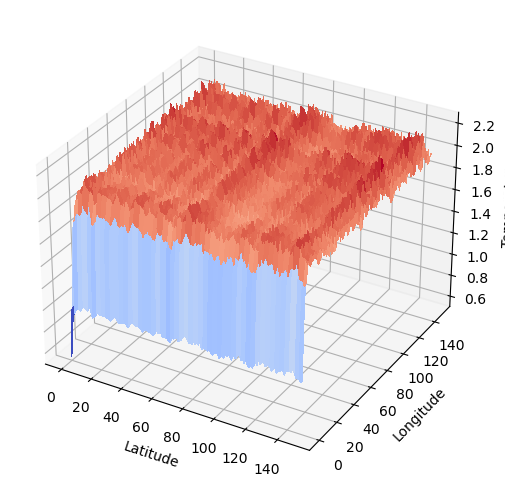

In [6]:
def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
    # keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)
# %%

Add trend on top of the AR variation -- to baseline thermal

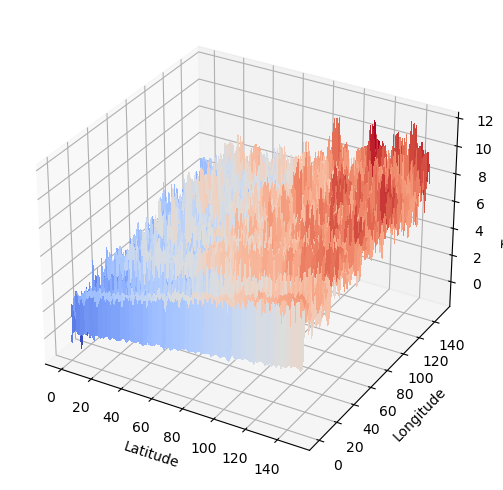

In [7]:
lat_inc_max = 5
long_inc_mu, long_inc_std = .01, .1

def add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size-horz_offest, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size-horz_offest,size-horz_offest), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)


plot_temperature_env(samp_inc)
# %%

Extend into atmosphere

In [8]:
#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/10, size=max_alt_Km)
# Temp at altitude = base temp - tempC_km * altitude
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * np.arange(max_alt_Km)*1000, (size-horz_offest,size-horz_offest,max_alt_Km)
    ).T
)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)
# %%

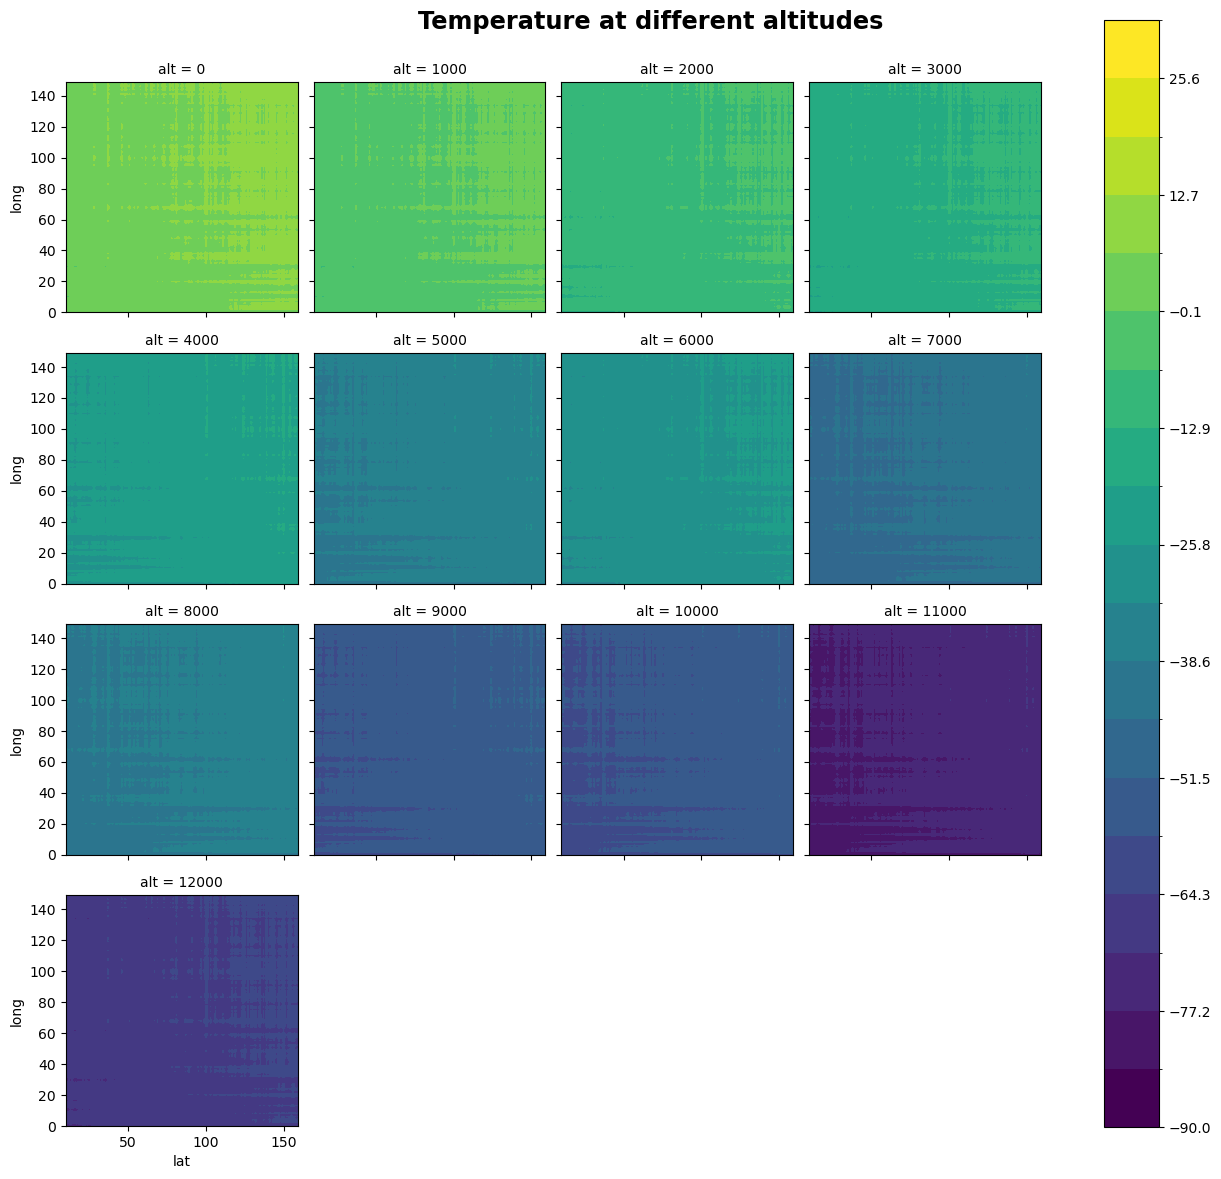

In [9]:
xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)

xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})

Calculate pressure based on baseline temp field and assumed L; 


In [10]:
# %%
#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    T = T +273.15
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    return P0 * (T / T0) ** (g0 * M / (R * L.mean()))


pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = xr_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)
   

In [11]:
pressure

<xarray.DataArray (lat: 150, long: 150, alt: 13)>
array([[[101325.        ,  89192.52384028,  76881.02119021, ...,
          26360.38085986,  15931.6306726 ,  20631.55028611],
        [101325.        ,  89178.40109519,  76854.29445857, ...,
          26310.79689408,  15888.34530294,  20584.55444508],
        [101325.        ,  89294.3263637 ,  77073.79961245, ...,
          26719.85530857,  16246.31581322,  20972.71156832],
        ...,
        [101325.        ,  89320.41678366,  77123.24001763, ...,
          26812.5652408 ,  16327.72223373,  21060.82597036],
        [101325.        ,  89299.91171588,  77084.38247767, ...,
          26739.68232311,  16263.71694461,  20991.55140616],
        [101325.        ,  89283.73760682,  77053.73828732, ...,
          26682.29701415,  16213.36557216,  20937.02981564]],

       [[101325.        ,  89211.26800287,  76916.5000983 , ...,
          26426.29728119,  15989.21922627,  20694.04948404],
        [101325.        ,  89201.6439494 ,  76898.28281034, ...,
          26392.43772617,  15959.63101106,  20661.94193505],
        [101325.        ,  89322.4255566 ,  77127.04714939, ...,
          26819.71310691,  16334.00280511,  21067.62168238],
...
        [101325.        ,  89606.35001819,  77665.9886538 , ...,
          27844.30219964,  17240.4105274 ,  22044.88163627],
        [101325.        ,  89577.98200079,  77612.06652088, ...,
          27740.64826086,  17148.16399613,  21945.73482311],
        [101325.        ,  89560.82738357,  77579.46690624, ...,
          27678.10587969,  17092.56374369,  21885.94219675]],

       [[101325.        ,  89320.98438985,  77124.31576622, ...,
          26814.58482465,  16329.49670816,  21062.74602405],
        [101325.        ,  89360.7617398 ,  77199.71976919, ...,
          26956.39663222,  16454.21697601,  21197.6304655 ],
        [101325.        ,  89498.75566053,  77461.55991968, ...,
          27452.6772786 ,  16892.52855214,  21670.61478253],
        ...,
        [101325.        ,  89568.80137135,  77594.61944798, ...,
          27707.16446964,  17118.39131868,  21913.72035156],
        [101325.        ,  89541.92869384,  77543.55994595, ...,
          27609.32598178,  17031.46987638,  21820.2126677 ],
        [101325.        ,  89512.99565973,  77488.60221443, ...,
          27504.27258746,  16938.26049925,  21719.87184611]]])
Coordinates:
  * lat      (lat) int32 10 11 12 13 14 15 16 17 ... 153 154 155 156 157 158 159
  * long     (long) int32 0 1 2 3 4 5 6 7 8 ... 142 143 144 145 146 147 148 149
  * alt      (alt) int32 0 1000 2000 3000 4000 ... 8000 9000 10000 11000 12000

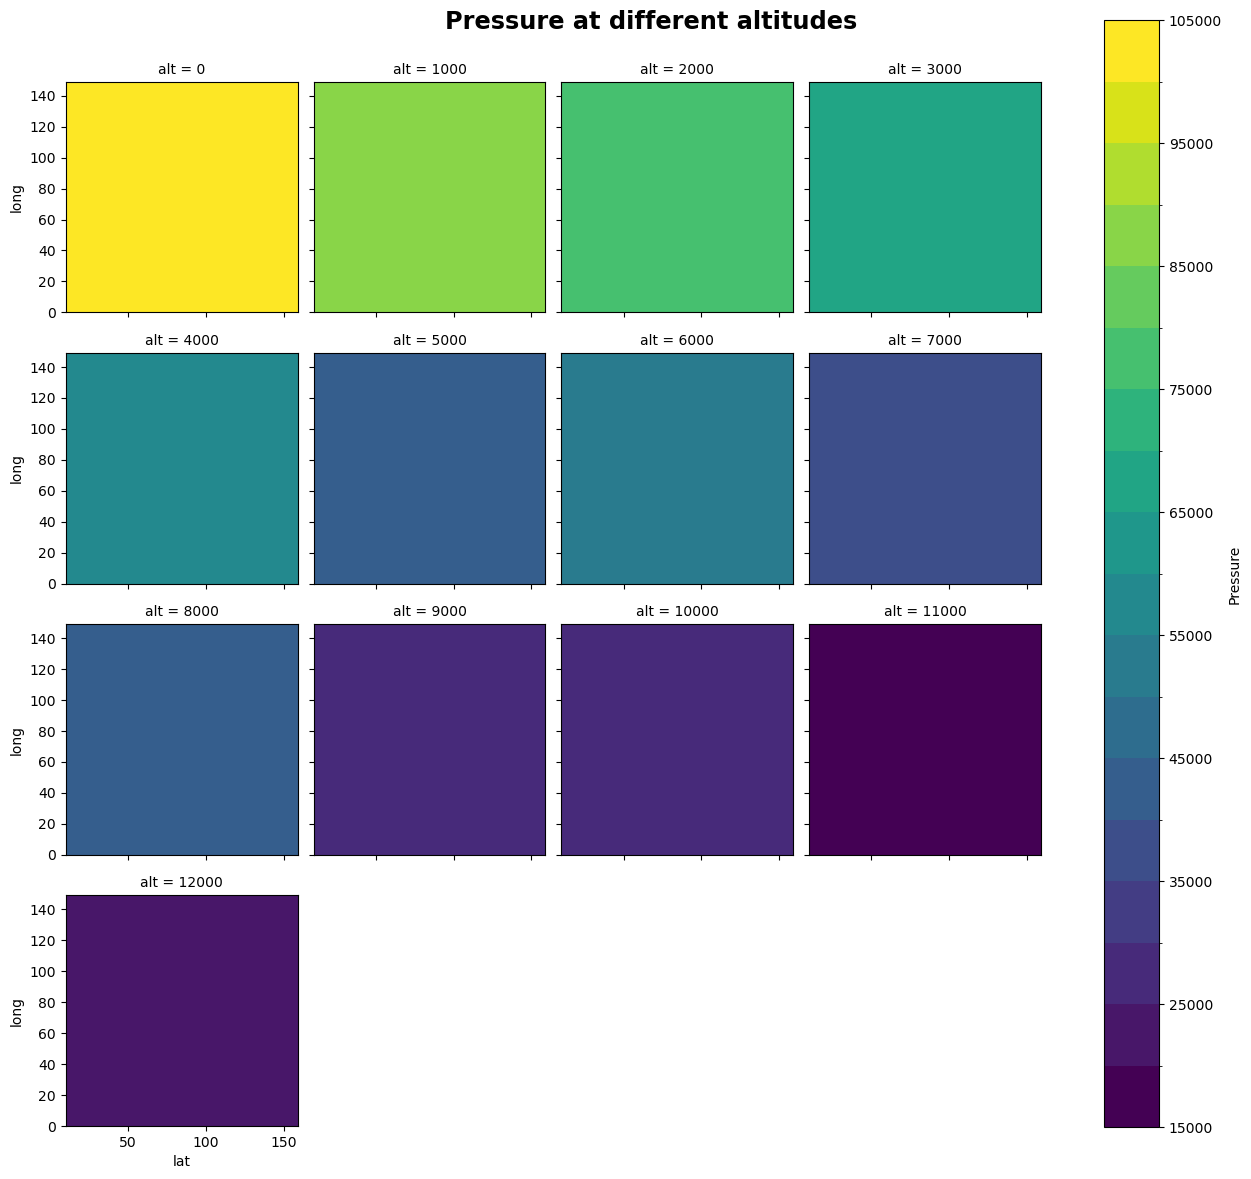

In [12]:
# %%
xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("Pressure")]
     )
# %%
xr_temp_pres.Pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('Pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)
# %%

# make trajectory and get corresponding temp and pres

In [60]:
time=pd.to_datetime( np.arange(0, 1000, 1), unit='s')
time

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 00:16:30', '1970-01-01 00:16:31',
               '1970-01-01 00:16:32', '1970-01-01 00:16:33',
               '1970-01-01 00:16:34', '1970-01-01 00:16:35',
               '1970-01-01 00:16:36', '1970-01-01 00:16:37',
               '1970-01-01 00:16:38', '1970-01-01 00:16:39'],
              dtype='datetime64[ns]', length=1000, freq=None)

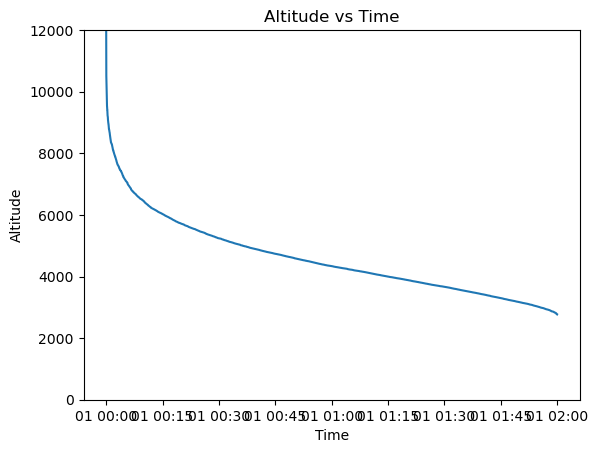

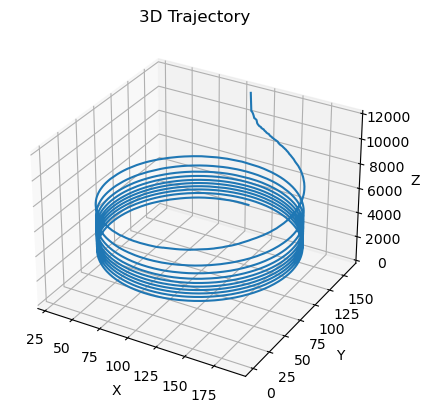

In [87]:
# %%
# make Z = a function of time and  X = sin of time and y = cos of time
time = pd.to_datetime( np.arange(0, 120*60, 1), unit='s')

release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1

turn_rate = 5
x = (np.sin((time.minute/60 +time.second/(60*60))*2*np.pi*turn_rate) +1) * size/2 +30
y = (np.cos((time.minute/60 +time.second/(60*60))*2*np.pi*turn_rate) +1 ) * size/2
#create samples from normal distribution and sort them
samples = stats.weibull_max.rvs(1.5, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
steps = samples/(samples.max()-samples.min()) /1.3  #normalize and shrink
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()
# %%

In [89]:
#select from xarray the temperature at the pressure of the trajectory
xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z)#, method='nearest')
xr_traj_env = xr_traj_env.interpolate_na(dim='time', method='linear', fill_value="extrapolate")
xr_traj_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')

xr_traj_env

<xarray.Dataset>
Dimensions:      (time: 7200)
Coordinates:
    long         (time) float64 160.0 160.0 160.0 160.0 ... 160.0 160.0 160.0
    alt          (time) float64 1.2e+04 1.056e+04 ... 2.77e+03 2.769e+03
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T01:59:59
    lat          (time) float64 110.0 110.7 111.4 112.1 ... 107.9 108.6 109.3
Data variables:
    Temperature  (time) float64 8.607 7.736 6.865 5.994 ... -49.6 -50.21 -50.82
    Pressure     (time) float64 2.718e+04 2.73e+04 ... 6.653e+04 6.648e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

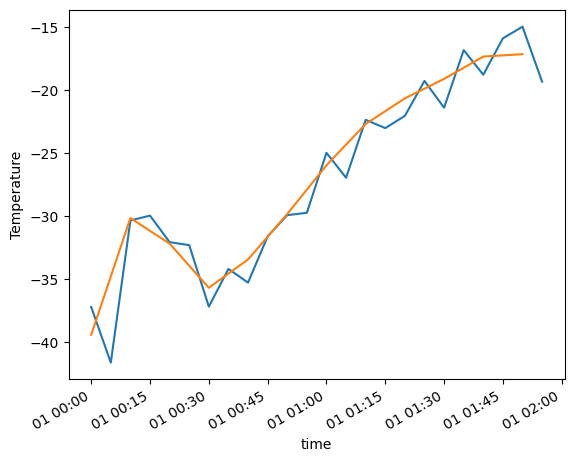

In [90]:
xr_traj_env.resample(time='5min').mean().Temperature.plot()
xr_traj_env.resample(time='10min').mean().Temperature.plot()

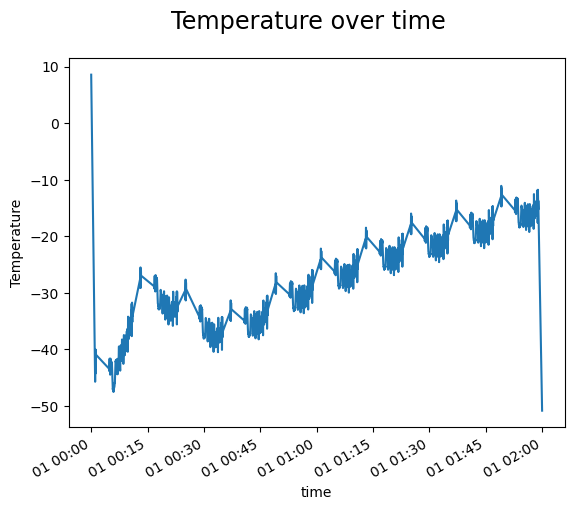

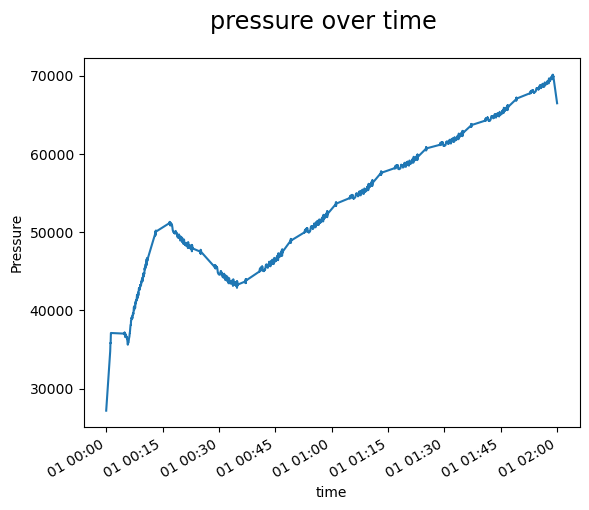

In [92]:
xr_traj_env.Temperature.plot()
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
xr_traj_env.Pressure.plot()
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()


In [ ]:
#add wind direction and speed then its velocity relvant to the trajectory
wind_direction = 180 #degrees from north is 0, from east is 90, from south is 180, from west is 270
wind_speed = 10 #m/s #TODO: add wind speed as a function of altitude and lat long
wind_speed_long = wind_speed * np.cos(np.deg2rad(wind_direction))
wind_speed_lat = wind_speed * np.sin(np.deg2rad(wind_direction))
wind_speed_z = 0
display('wind_speed_long',wind_speed_long, 
        'wind_speed_lat',wind_speed_lat, 
        'wind_speed_z',wind_speed_z)
# %%

In [ ]:
#add wind velocity relevant to the trajectory; dont add wind in
if False:
    xr_traj_env['wind_speed_long'] = wind_speed_long
    xr_traj_env['wind_speed_lat'] = wind_speed_lat
    xr_traj_env['wind_speed_z'] = wind_speed_z
    xr_traj_env['wind_speed'] = np.sqrt(wind_speed_long**2 + wind_speed_lat**2 + wind_speed_z**2)
    xr_traj_env['wind_direction'] = wind_direction
    xr_traj_env=xr_traj_env.interpolate_na(dim='time', method='linear', limit=None, use_coordinate=True, fill_value='extrapolate')
    xr_traj_env
# %%

# Using Xarray resampling

In [186]:
xr_traj_env

TypeError: 'in <string>' requires string as left operand, not ellipsis

In [160]:
#downsample from xarray
#must be a datetime index in xarray
# move xarray coordinate to variable
xr_traj_env_time = xr_traj_env.reset_coords(['lat','long','alt'], drop=False)
xr_traj_env_time = xr_traj_env_time.resample(time='5min', restore_coord_dims=True).mean()
xr_traj_env_time_coords = xr_traj_env_time
#Move variable to xarray coordinate
xr_traj_env_time = xr_traj_env_time.drop(['lat','long','alt'])
xr_traj_env_time = xr_traj_env_time.expand_dims({"lat":xr_traj_env_time_coords.lat.values, 
                              'long':xr_traj_env_time_coords.long.values, 
                              'alt':xr_traj_env_time_coords.alt.values}) 


In [165]:
# toDO CHANGE THIS VARIABLE BELOW HERE
#xarray make a multiindex of lat long alt and time

#grp_traj_env = 
xr_traj_env_time.stack(alt_lat_long_time=['alt','lat','long','time'],create_index=True)
xr_traj_env_time

<xarray.Dataset>
Dimensions:      (lat: 24, long: 24, alt: 24, time: 24)
Coordinates:
  * lat          (lat) float64 167.0 68.44 125.0 125.5 ... 94.47 151.9 52.91
  * long         (long) float64 95.53 38.08 137.1 23.05 ... 137.0 38.44 95.03
  * alt          (alt) float64 8.033e+03 6.744e+03 ... 3.097e+03 2.917e+03
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T01:55:00
Data variables:
    Temperature  (lat, long, alt, time) float64 -37.21 -41.63 ... -14.98 -19.34
    Pressure     (lat, long, alt, time) float64 3.572e+04 4.01e+04 ... 6.89e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

# Using average values per Km; TODO: find more principled way to remove autocorrelation 

In [ ]:
bins_alt = np.linspace(alt.min(), alt.max(), 11)
bins_lat =[lat.min(), lat.mean(),lat.max()] #quadrents
bins_long = [long.min(), long.mean(), long.max()]# quadrents
bins_time = np.arange(time.min(), time.max()+1, 10)

In [108]:
#grouping lat long and alt
if False:
  grp_traj_env=xarray_reduce(xr_traj_env.drop_vars(['wind_speed_long', 'wind_speed_lat', 'wind_speed_z', 'wind_speed', 'wind_direction']),
               'alt', 'lat', 'long',
                 func='mean',
                 expected_groups=(
                            pd.IntervalIndex.from_breaks(bins_alt, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_lat, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_long, closed='left')
                        ))
  grp_traj_env

In [ ]:
#grouping lat long and alt and time
grp_traj_env=xarray_reduce(xr_traj_env, #.drop_vars(['wind_speed_long', 'wind_speed_lat', 'wind_speed_z', 'wind_speed', 'wind_direction']),
               'alt', 'lat', 'long', 'time',
                 func='mean',
                 expected_groups=(
                            pd.IntervalIndex.from_breaks(bins_alt, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_lat, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_long, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_time, closed='left')
                        ))

grp_traj_env = grp_traj_env.stack(alt_lat_long_time=(
    'alt_bins', 
    'lat_bins', 
    'long_bins',
    'time_bins')).dropna(dim='alt_lat_long_time')

grp_traj_env.coords

# Model temp and pressure varying by altitude, lat, & long

In [152]:

coords={'alt_lat_long_time':
                      np.arange(xr_traj_env_time.sizes['time'], dtype=int)
                      }
coords

{'alt_lat_long_time': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23])}

used t[0]
<class 'pytensor.tensor.var.TensorVariable'>


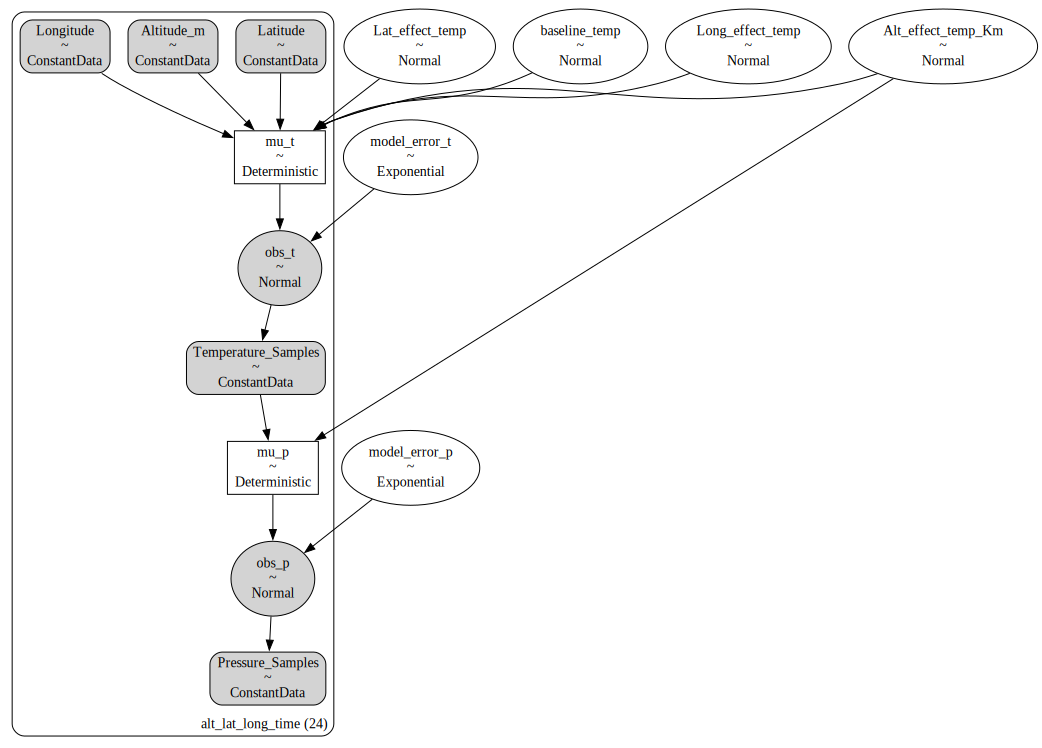

In [149]:
with pm.Model(coords=coords) as thermal_pres:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', xr_traj_env_time_coords.alt.values,#[bin_item.mid for bin_item in grp_traj_env.alt_bins.values], 
                                          dims='alt_lat_long_time' )
    Lat_ = pm.ConstantData('Latitude', xr_traj_env_time_coords.lat.values,# [bin_item.mid for bin_item in grp_traj_env.lat_bins.values],
                                        dims='alt_lat_long_time' )
    Long_ = pm.ConstantData('Longitude', xr_traj_env_time_coords.long.values,#[bin_item.mid for bin_item in grp_traj_env.long_bins.values],
                                          dims='alt_lat_long_time' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env_time_coords.Temperature.values, dims='alt_lat_long_time' )
    Pres_ = pm.ConstantData('Pressure_Samples', xr_traj_env_time_coords.Pressure.values, dims='alt_lat_long_time' )
    #prior on effect on temp (degC) of altitude and lat, long
    baseline_temp = pm.Normal('baseline_temp', mu=0, sigma=20) #'L'
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=-6, sigma=2)
    Lat_effect_temp = pm.Normal('Lat_effect_temp', mu=0, sigma=1)
    Long_effect_temp = pm.Normal('Long_effect_temp', mu=0, sigma=1)
    #prior on temp and pressure
    #TODO: PULL FROM DATABASE into a pm.Interpolated...maybe not: need relationship between data spreads?
    mu_t = pm.Deterministic('mu_t',
                               baseline_temp + Alt_effect_temp/1000 * Alt_ + Lat_effect_temp * Lat_ + Long_effect_temp * Long_, 
                               dims='alt_lat_long_time')
    #mu_t = hierarchical_normal('temperature_mean', mu= mu_mu_t, sigma = 2, dims='alt_lat_long_time')
    #mu_p = hierarchical_normal('pressure_mean', 
    mu_p= pm.Deterministic('mu_p',add_barometric_effects(T = Temp_, 
                                 L = Alt_effect_temp/1000, H = Alt_,  
                                 P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598),
                                 dims='alt_lat_long_time')
    #add_barometric_effects = P0 * (T/T0) ** (g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/0.025)
    sigma_p=pm.Exponential('model_error_p', 10/1)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t, 
                    observed = Temp_, dims='alt_lat_long_time')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p, 
                    observed = Pres_, dims='alt_lat_long_time')
    
pm.model_to_graphviz(thermal_pres)

Sampling: [Alt_effect_temp_Km, Lat_effect_temp, Long_effect_temp, baseline_temp, model_error_p, model_error_t, obs_p, obs_t]


array([<Axes: xlabel='obs_t / obs_t'>, <Axes: xlabel='obs_p / obs_p'>],
      dtype=object)

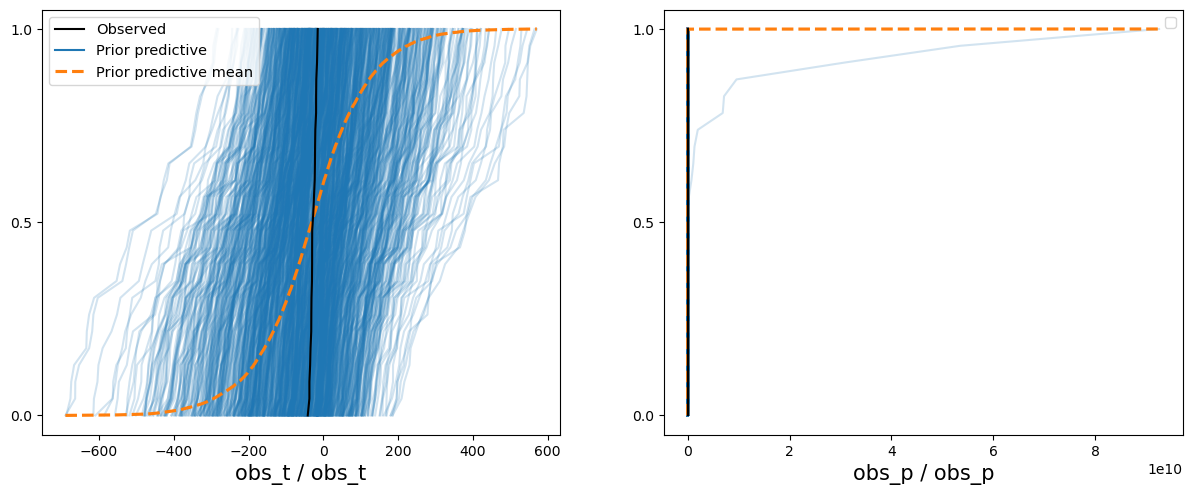

In [150]:
with thermal_pres:
    idata2 = pm.sample_prior_predictive(1000)
az.plot_ppc(idata2, group='prior', kind='cumulative')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_temp, Alt_effect_temp_Km, Lat_effect_temp, Long_effect_temp, model_error_t, model_error_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


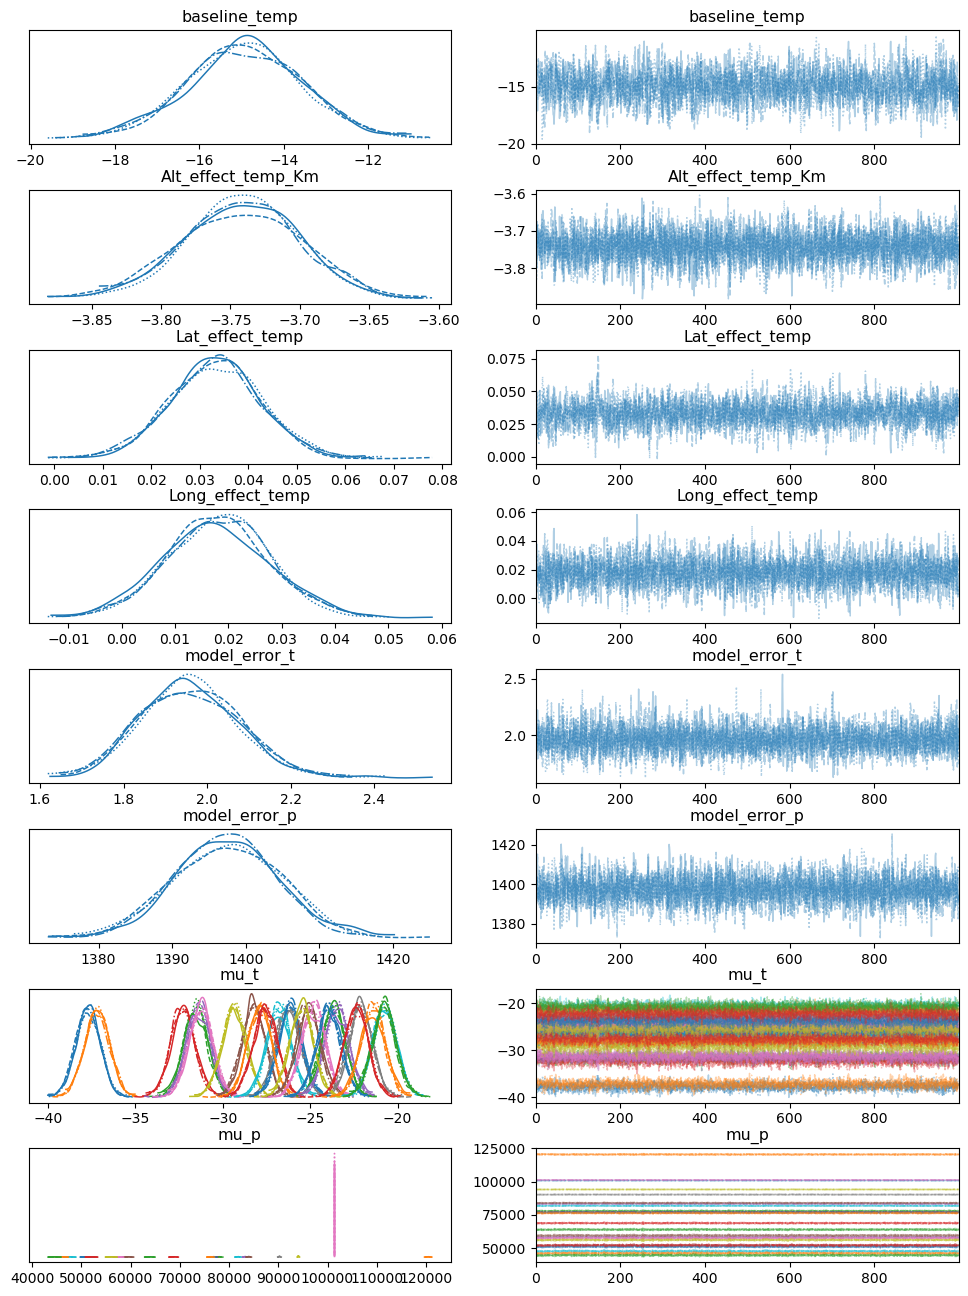

In [151]:
with thermal_pres:
    idata2.extend(pm.sample(1000, tune=1000,  nuts=dict(max_treedepth=15, target_accept=0.9)))
    az.plot_trace(idata2)
    plt.subplots_adjust (hspace=0.4)#, wspace=0.4) 
    

In [228]:
#xarray filter by values
lat_min = idata2.constant_data.Latitude.min()
lat_max = idata2.constant_data.Latitude.max()
long_min = idata2.constant_data.Longitude.min()
long_max = idata2.constant_data.Longitude.max()
lat_mid = (lat_min + lat_max)/2
long_mid = (long_min + long_max)/2


idx_north = idata2.constant_data.where(idata2.constant_data.Latitude>lat_mid, drop=True).alt_lat_long_time.values
idx_south = idata2.constant_data.where(idata2.constant_data.Latitude<lat_mid, drop=True).alt_lat_long_time.values
idx_east = idata2.constant_data.where(idata2.constant_data.Longitude>long_mid, drop=True).alt_lat_long_time.values
idx_west = idata2.constant_data.where(idata2.constant_data.Longitude<long_mid, drop=True).alt_lat_long_time.values


In [240]:
idata2.sel(alt_lat_long_time=np.intersect1d(idx_north,idx_east))

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [148]:
def reset_multi_dim(need_it_expanded, have_it, dims):
    """Reset the dims of a xarray to match another xarray"""    
    for dim in dims:
        if dim in have_it.dims:
            try:
                need_it_expanded[dim] = have_it[dim]
                need_it_expanded= need_it_expanded.unstack(dim)
            except:
                pass#need_it_expanded = need_it_expanded.assign_coords({dim: have_it[dim]})
            
    return need_it_expanded

idata2.map(reset_multi_dim, have_it=xr_traj_env_time_coords, dims=['alt_lat_long_time'])
display(idata2)

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [269]:
idata3.posterior['alt_lat_long_time']  = idata3.constant_data.Altitude_m
idata3

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [260]:
{f'mu_t[{i}]': alti for i, alti in zip(idata2.constant_data.alt_lat_long_time.values,
                                                                             idata2.constant_data.Altitude_m.values)}

{'mu_t[0]': 8032.941799758064,
 'mu_t[1]': 6743.768747513472,
 'mu_t[2]': 6209.812954486391,
 'mu_t[3]': 5864.939382548849,
 'mu_t[4]': 5588.854859547941,
 'mu_t[5]': 5351.4123031132285,
 'mu_t[6]': 5144.380500130719,
 'mu_t[7]': 4964.106839238869,
 'mu_t[8]': 4809.643285385148,
 'mu_t[9]': 4670.591832580822,
 'mu_t[10]': 4530.361823994999,
 'mu_t[11]': 4395.058166449707,
 'mu_t[12]': 4280.84150788596,
 'mu_t[13]': 4171.472911923895,
 'mu_t[14]': 4055.6357048346467,
 'mu_t[15]': 3944.4893071418837,
 'mu_t[16]': 3831.059063462648,
 'mu_t[17]': 3717.8919059773316,
 'mu_t[18]': 3607.0104269749354,
 'mu_t[19]': 3487.572409386716,
 'mu_t[20]': 3362.9310457325714,
 'mu_t[21]': 3232.304561264355,
 'mu_t[22]': 3097.118095765905,
 'mu_t[23]': 2917.0780911555785}

North West
North East
South West
South East


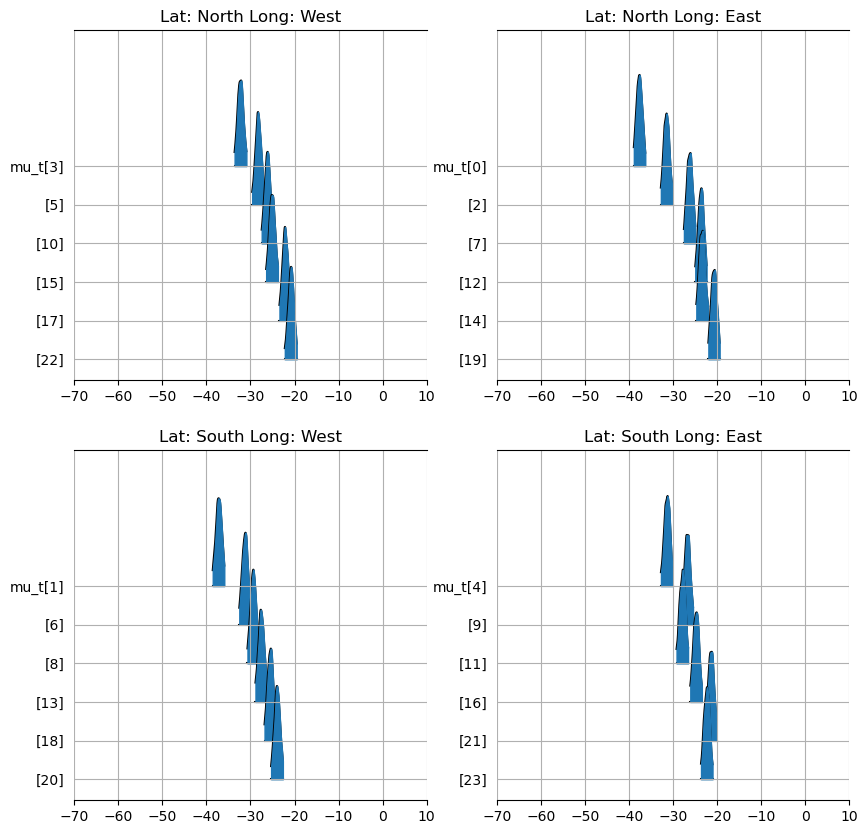

In [277]:

#figures with lat in coulmns and long in rows
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i, ((N_S_label,N_S_idx), (E_W_label,E_W_idx)) in enumerate([[i,j] 
                                  for i in [('North',idx_north),('South',idx_south)] 
                                  for j in [('West',idx_west), ('East',idx_east)]]):
    print(N_S_label,E_W_label)
    ax[i].set_title(f'Lat: {N_S_label} Long: {E_W_label}')
    idx = np.intersect1d(N_S_idx,E_W_idx)
    az.plot_forest(idata2.sel(alt_lat_long_time=idx), 
                   var_names=['mu_t'],
                   kind='ridgeplot', 
                   combined=True, ax= ax[i],
                   #labeller=labeller
                   )
    #align the y axis
    #ax[i].set_ylim(0, 10000)
    ax[i].set_xlim(-70, 10)
    ax[i].grid()


array([<Axes: >], dtype=object)

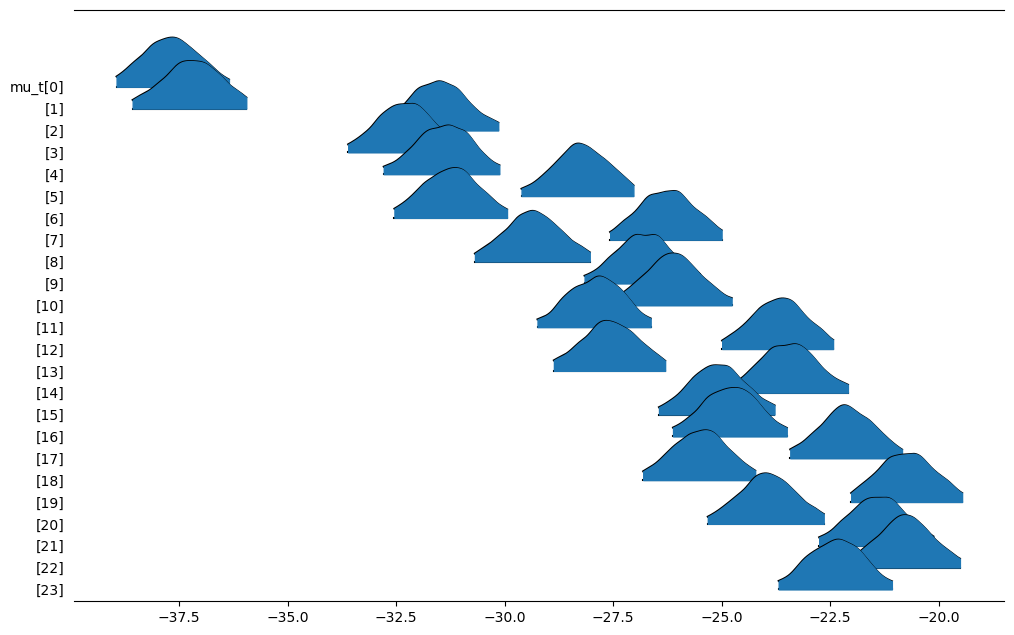

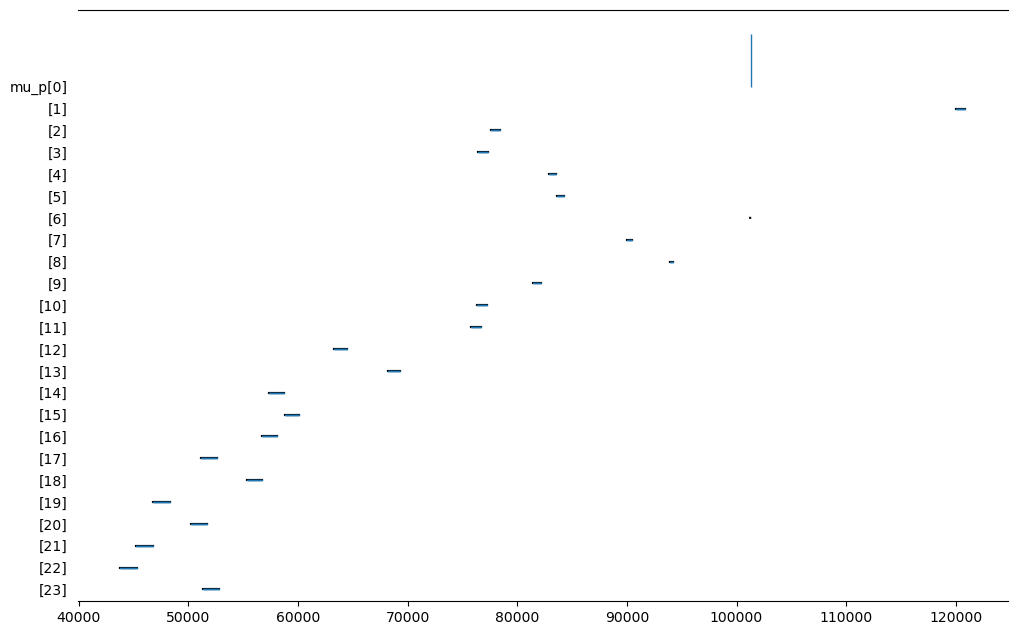

In [247]:
az.plot_forest(idata2, var_names=['mu_t'],kind='ridgeplot', combined=True)#,combine_dims='time_bins')
az.plot_forest(idata2, var_names=['mu_p'],kind='ridgeplot', combined=True)

In [ ]:
with thermal_pres:
    # pymc sample posterior predictive check
    pm.sample_posterior_predictive(idata2, extend_inferencedata=True)
    az.plot_ppc(idata2, group='posterior', kind='cumulative')


In [ ]:
az.plot_dist_comparison(idata2, kind='observed')
